In [1]:
%load_ext sql

In [2]:
%sql sqlite:////nbdb/results/metrics.db

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import sys
sys.path.append('../src')

import sqlite3
import typing as tp
from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from omegaconf import OmegaConf

from data.convolution import convolve
from imutils import norm_values, imshow
from constants import IMAGE_SIZE, MAX_UINT8, MAX_UINT16
from data.convertation import linrgbf_to_srgbf
from deconv.classic.wiener.wiener import wiener_gray
from deconv.neural.usrnet.predictor import USRNetPredictor
from deconv.neural.dwdn.predictor import DWDNPredictor
from deconv.neural.kerunc.predictor import KerUncPredictor
from metrics import psnr, ssim

from services.tester import MainTester

plt.gray()

np.random.seed(8)

<Figure size 640x480 with 0 Axes>

In [5]:
config = OmegaConf.load('../configs/config_viz_cuda.yml')
cm = config.models

models = dict()

models['wiener'] = dict()
models['wiener']['noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.noise_params)
models['wiener']['no_noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.no_noise_params)

models['kerunc'] = dict()
models['kerunc']['noise'] = KerUncPredictor(**cm.kerunc.noise_params)
models['kerunc']['no_noise'] = KerUncPredictor(**cm.kerunc.no_noise_params)

models['usrnet'] = dict()
models['usrnet']['noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.noise_params)
models['usrnet']['no_noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params)

models['dwdn'] = dict()
models['dwdn']['noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.noise_params)
models['dwdn']['no_noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.no_noise_params)

In [6]:
NOISE_MU = config.dataset.blur.mu
NOISE_STD = config.dataset.blur.sigma
IMAGE_SIZE = 256
DISCRETIZATION_TYPE = 'linrgb_float'

print(f'noise mu: {NOISE_MU}, std: {NOISE_STD}')

noise mu: 0, std: 0.01


# Тестирование качества восстановления

## 1. Сравнение качества восстановления по различным типам размытия

### Метрики

In [7]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model,
       noised,
       CASE
         WHEN kernel LIKE '%big%' THEN blur_type || '_big'
         WHEN kernel LIKE '%medium%' THEN blur_type || '_medium'
         WHEN kernel LIKE '%small%' THEN blur_type || '_small'
         ELSE blur_type
       END AS blur_type_detailed,
       psnr,
       ssim
FROM main_FULL_16_05_v2
WHERE discretization == 'linrgb_float'
''', conn)

result_set.head()

model  noised blur_type_detailed       psnr      ssim
0     wiener_blind_noise       0    eye_blur_medium  14.286763  0.626906
1     wiener_blind_noise       1    eye_blur_medium  15.645561  0.384088
2  wiener_nonblind_noise       0    eye_blur_medium  39.564175  0.990652
3  wiener_nonblind_noise       1    eye_blur_medium  15.958477  0.490073
4                 kerunc       0    eye_blur_medium  20.685601  0.620554

In [8]:
result_set_wiener = pd.read_sql_query(
'''
SELECT model,
       noised,
       CASE
         WHEN kernel LIKE '%big%' THEN blur_type || '_big'
         WHEN kernel LIKE '%medium%' THEN blur_type || '_medium'
         WHEN kernel LIKE '%small%' THEN blur_type || '_small'
         ELSE blur_type
       END AS blur_type_detailed,
       psnr,
       ssim
FROM main_wiener_lin_full_v2
WHERE discretization == 'linrgb_float'
''', conn)

result_set_wiener.head()

model  noised blur_type_detailed       psnr      ssim
0  wiener_nonblind_noise       0    eye_blur_medium  39.564175  0.990652
1  wiener_nonblind_noise       1    eye_blur_medium  15.958477  0.490073
2  wiener_nonblind_noise       0    eye_blur_medium  46.004995  0.997192
3  wiener_nonblind_noise       1    eye_blur_medium  23.224443  0.616638
4  wiener_nonblind_noise       0    eye_blur_medium  43.296040  0.995785

In [9]:
def set_medians(data, ax, medians):
    pos = range(1, len(data)+1)
    for tick, label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick-1], medians[tick-1], str(medians[tick-1]), 
                horizontalalignment='center',  color='black', weight='semibold', fontsize=8)


def draw_boxplot(axs, result_set: pd.DataFrame, metric_name: str, model_name: str, noised: bool, idx: int, idy: int):
    blur_types = ['gauss_blur', 'motion_blur', 'eye_blur_small', 'eye_blur_medium', 'eye_blur_big']
    data = [result_set[(result_set['model'] == model_name) & (result_set['blur_type_detailed'] == blur_type) & (result_set['noised'] == noised)][metric_name] for blur_type in blur_types]
    
    medians = [np.round(np.median(d), 2) for d in data]
    axs[idx, idy].boxplot(data)
    if idx == 1:
        axs[idx, idy].set_xticks([i for i in range(1, 6)], blur_types, rotation=30)
    if idy == 0:
        axs[idx, idy].set_ylabel(metric_name.upper())
    if metric_name == 'psnr':
        if noised:
            axs[idx, idy].set_ylim(0.0, 50)
        else:
            axs[idx, idy].set_ylim(0.0, 110)
    if metric_name == 'ssim':   
        axs[idx, idy].set_ylim(0.0, 1.1)
    axs[idx, idy].set_title(model_name.split('_')[0])
    set_medians(data, axs[idx, idy], medians)

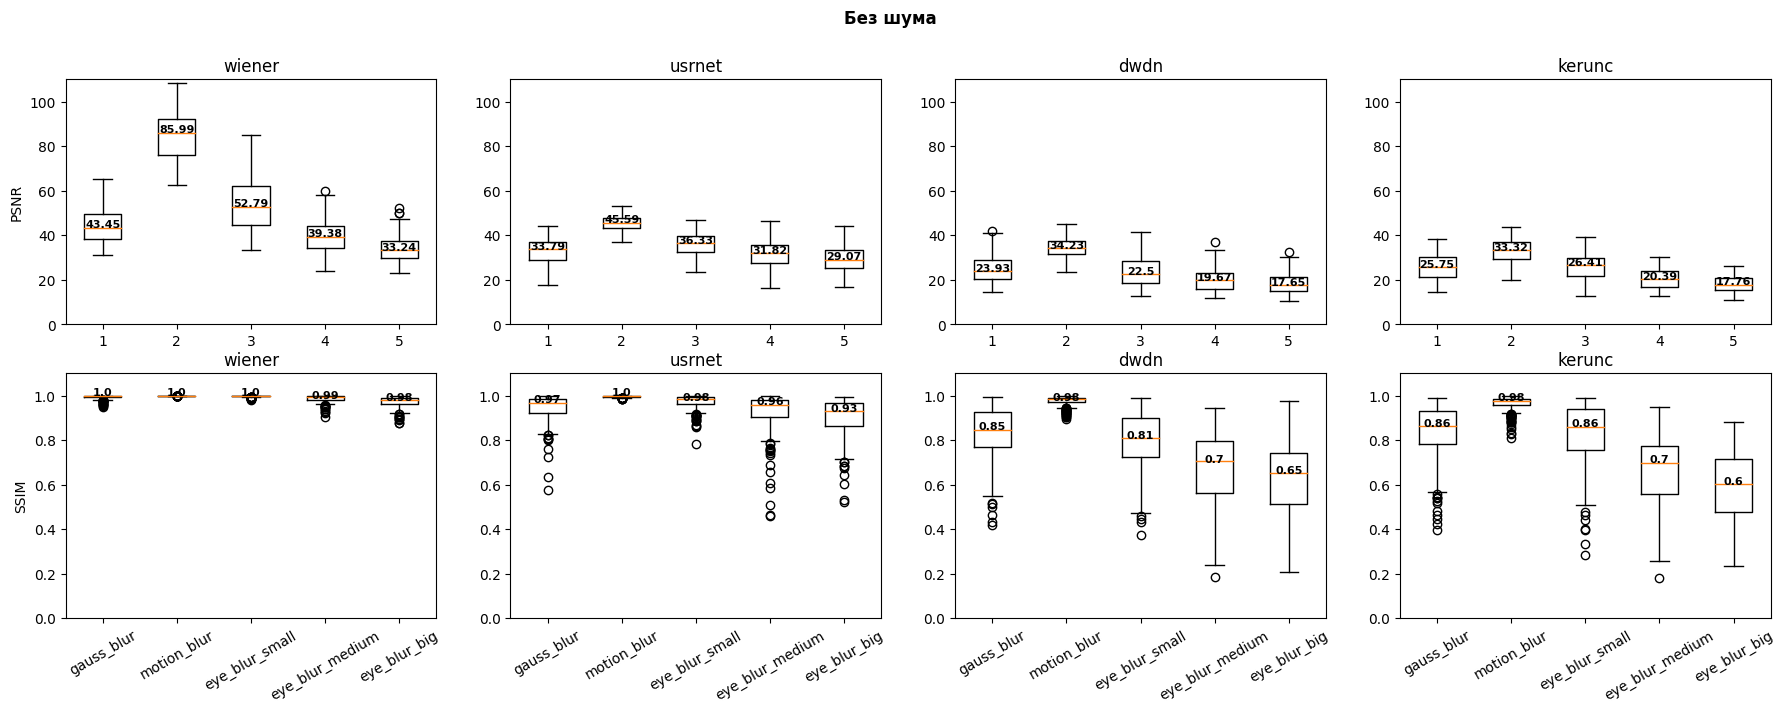

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(22, 7))
fig.suptitle('Без шума', weight='semibold',)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='wiener_nonblind_noise', noised=False, idx=0, idy=0)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='usrnet', noised=False, idx=0, idy=1)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='dwdn', noised=False, idx=0, idy=2)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='kerunc', noised=False, idx=0, idy=3)

draw_boxplot(axs, result_set, metric_name='ssim', model_name='wiener_nonblind_noise', noised=False, idx=1, idy=0)
draw_boxplot(axs, result_set, metric_name='ssim', model_name='usrnet', noised=False, idx=1, idy=1)
draw_boxplot(axs, result_set, metric_name='ssim', model_name='dwdn', noised=False, idx=1, idy=2)
draw_boxplot(axs, result_set, metric_name='ssim', model_name='kerunc', noised=False, idx=1, idy=3)

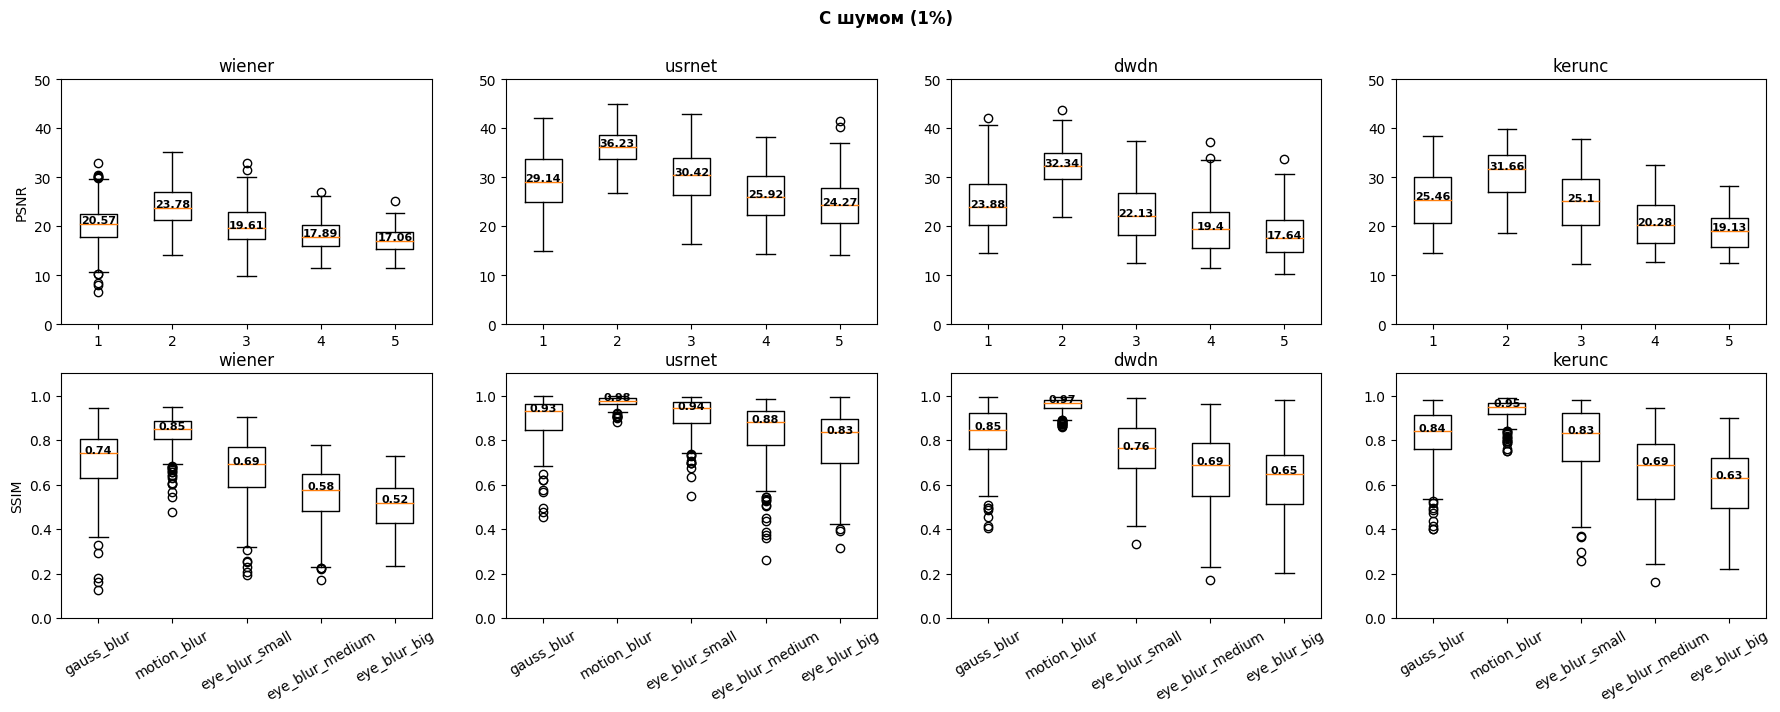

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(22, 7))
fig.suptitle('С шумом (1%)', weight='semibold',)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='wiener_nonblind_noise', noised=True, idx=0, idy=0)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='usrnet', noised=True, idx=0, idy=1)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='dwdn', noised=True, idx=0, idy=2)
draw_boxplot(axs, result_set, metric_name='psnr', model_name='kerunc', noised=True, idx=0, idy=3)

draw_boxplot(axs, result_set, metric_name='ssim', model_name='wiener_nonblind_noise', noised=True, idx=1, idy=0)
draw_boxplot(axs, result_set, metric_name='ssim', model_name='usrnet', noised=True, idx=1, idy=1)
draw_boxplot(axs, result_set, metric_name='ssim', model_name='dwdn', noised=True, idx=1, idy=2)
draw_boxplot(axs, result_set, metric_name='ssim', model_name='kerunc', noised=True, idx=1, idy=3)

### Визуализация

In [12]:
def _1d_t0_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])

def viz(
    image: np.ndarray,
    psf: np.ndarray,
    blurred: tp.Dict[str, tp.Dict[str, np.ndarray]],
    noised_blurred: tp.Dict[str, tp.Dict[str, np.ndarray]],
    models: dict,
    is_srgb: bool,
):
    if is_srgb:
        viz_preprocess = lambda image: linrgbf_to_srgbf(_1d_t0_3d(image))
    else:
        viz_preprocess = lambda image: _1d_t0_3d(image)

    fig, ax = plt.subplots(3, 4, figsize=(12, 9))

    ax[0, 0].imshow(psf)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('PSF')

    ax[0, 1].imshow(viz_preprocess(blurred['1d']))
    ax[0, 1].axis('off')
    ax[0, 1].set_title('Blurred')

    ax[0, 2].imshow(viz_preprocess(noised_blurred['1d']))
    ax[0, 2].axis('off')
    ax[0, 2].set_title('Noised blurred')

    if image.max() > 1:
        image = np.clip(image, 0, 1)
    ax[0, 3].imshow(viz_preprocess(image))
    ax[0, 3].axis('off')
    ax[0, 3].set_title(f'Original image')

    for i, model_name in enumerate(models.keys()):
        model = models[model_name]['no_noise']
        restored = (
            model((blurred['3d']).astype(np.float32), psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model((blurred['1d']).astype(np.float32), psf)
        )
        restored = np.clip(restored, 0, 1)
        ax[1, i].imshow(viz_preprocess(restored))
        ax[1, i].axis('off')
        ax[1, i].set_title(f'{model_name}\nSSIM: {ssim(image, restored):.2f}, PSNR: {psnr(image, restored):.2f}')

    for i, model_name in enumerate(models.keys()):
        model = models[model_name]['noise']
        restored = (
            model((noised_blurred['3d']).astype(np.float32), psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model((noised_blurred['1d']).astype(np.float32), psf)
        )
        restored = np.clip(restored, 0, 1)
        ax[2, i].imshow(viz_preprocess(restored))
        ax[2, i].axis('off')
        ax[2, i].set_title(f'{model_name}\nSSIM: {ssim(image, restored):.2f}, PSNR: {psnr(image, restored):.2f}')
 
    ax[1, 0].set_ylabel('Without noise')
    ax[2, 0].set_ylabel('With noise')

#### Motion blur

##### 1

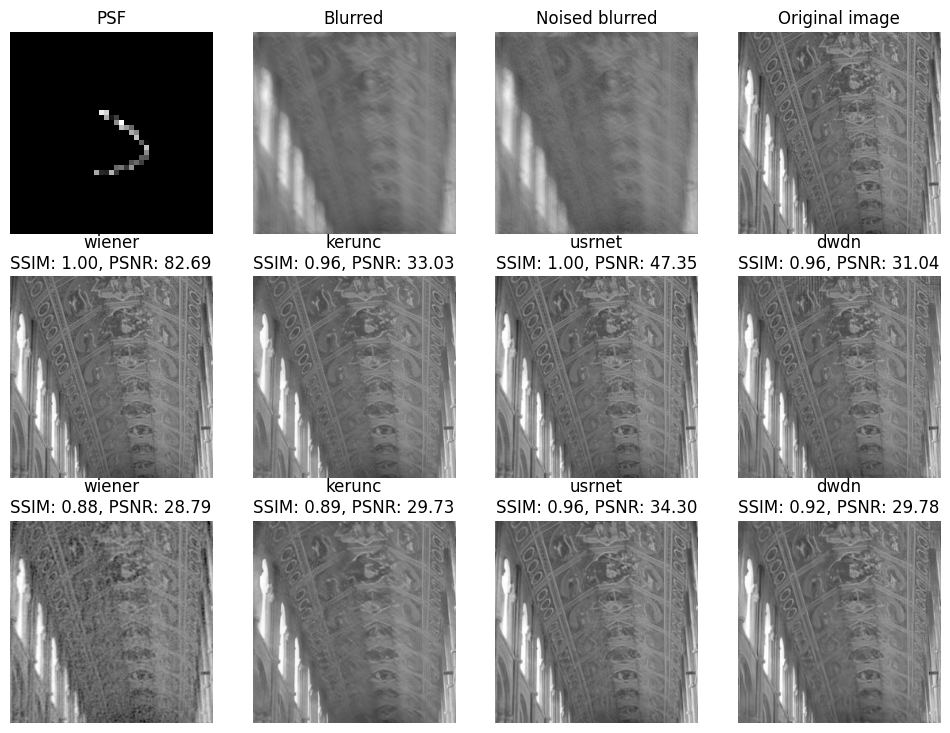

In [13]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/Sun-gray/im_18.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-13.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=True,
)

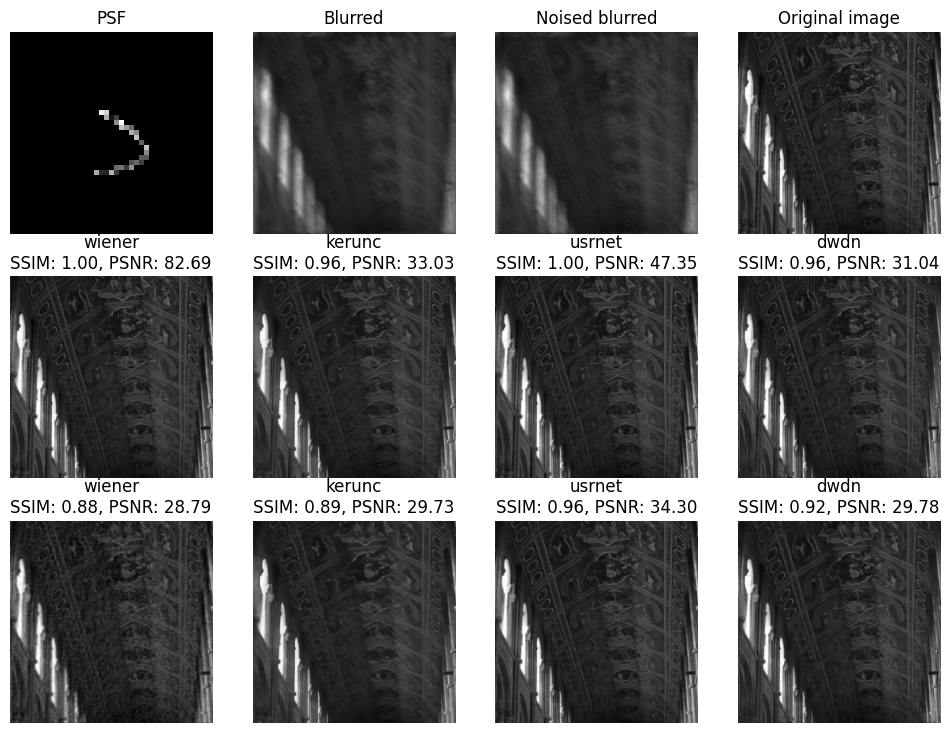

In [14]:
viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=False,
)

##### 2

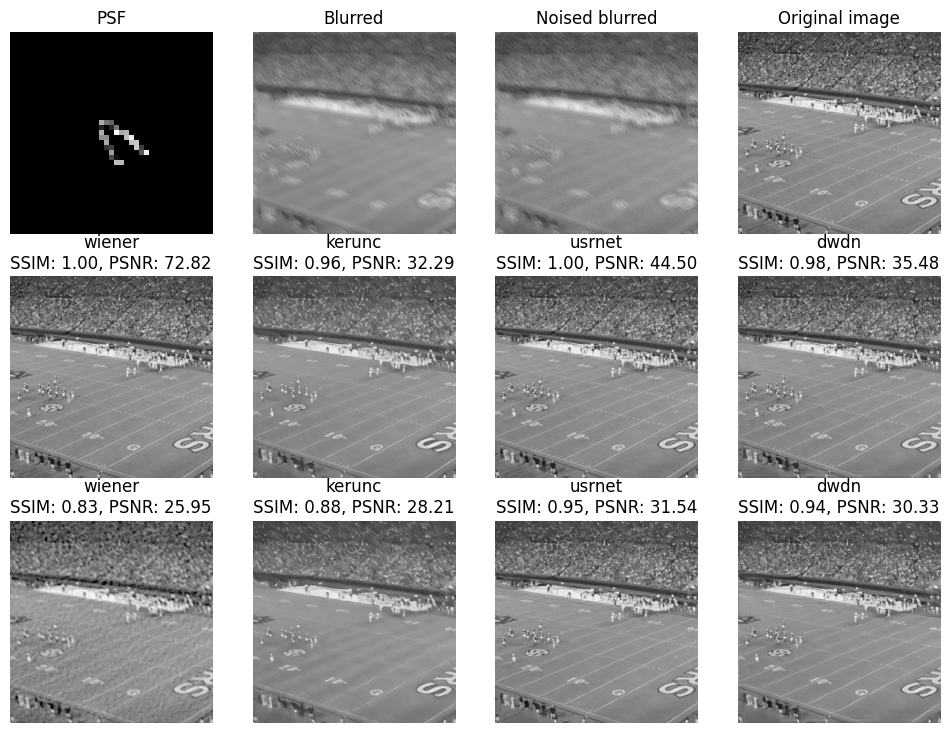

In [15]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/Sun-gray/im_60.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-19.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=True,
)

#### Gauss blur

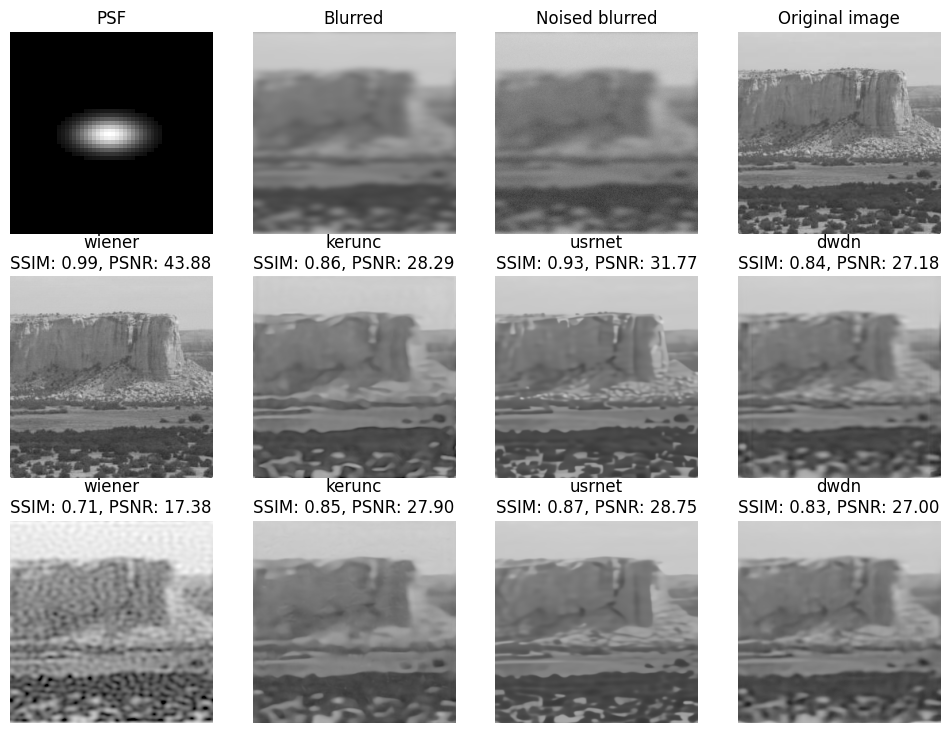

In [16]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/Sun-gray/im_12.png',
    psf_path='../datasets/kernels/gauss-blur/processed/synthetic/synthetic-18.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=True,
)

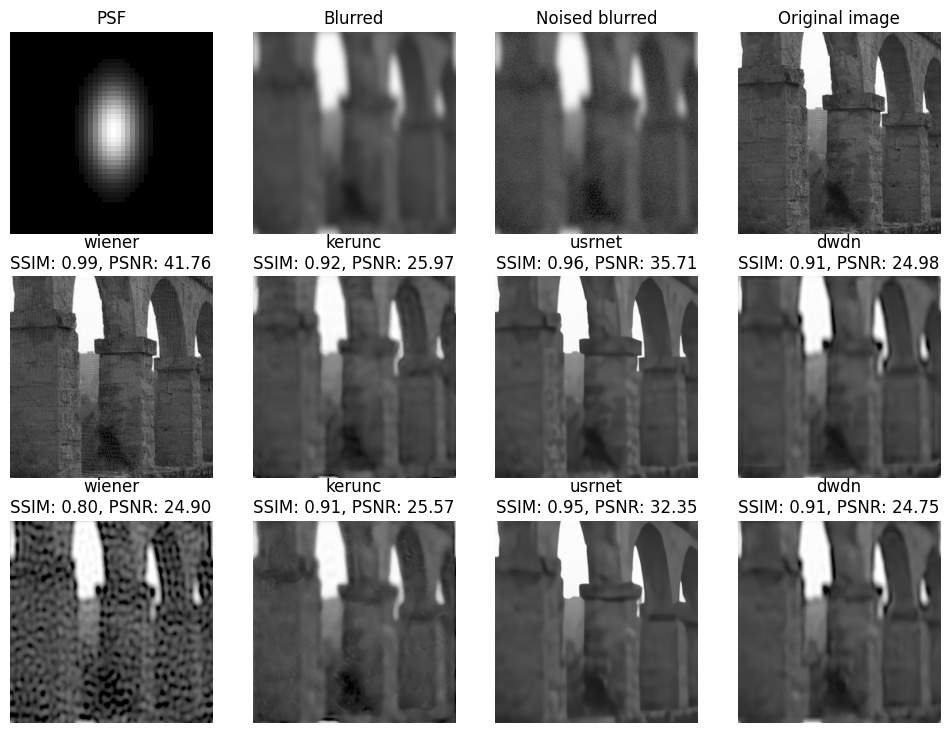

In [17]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/Sun-gray/im_2.png',
    psf_path='../datasets/kernels/gauss-blur/processed/synthetic/synthetic-8.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=True,
)

#### Eye blur

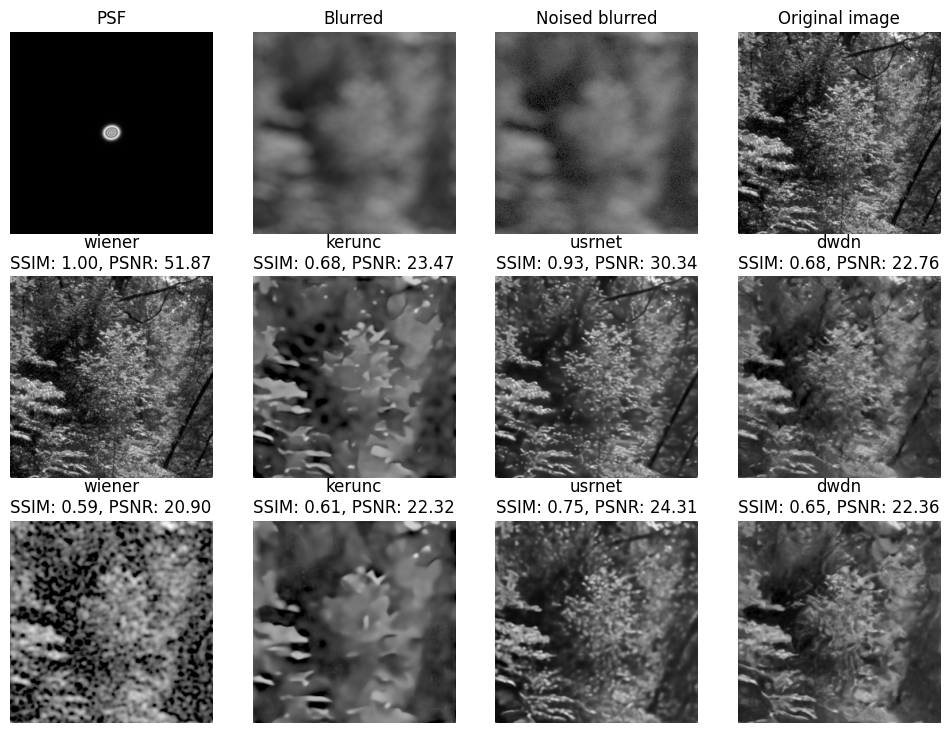

In [18]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/Sun-gray/im_32.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=True,
)

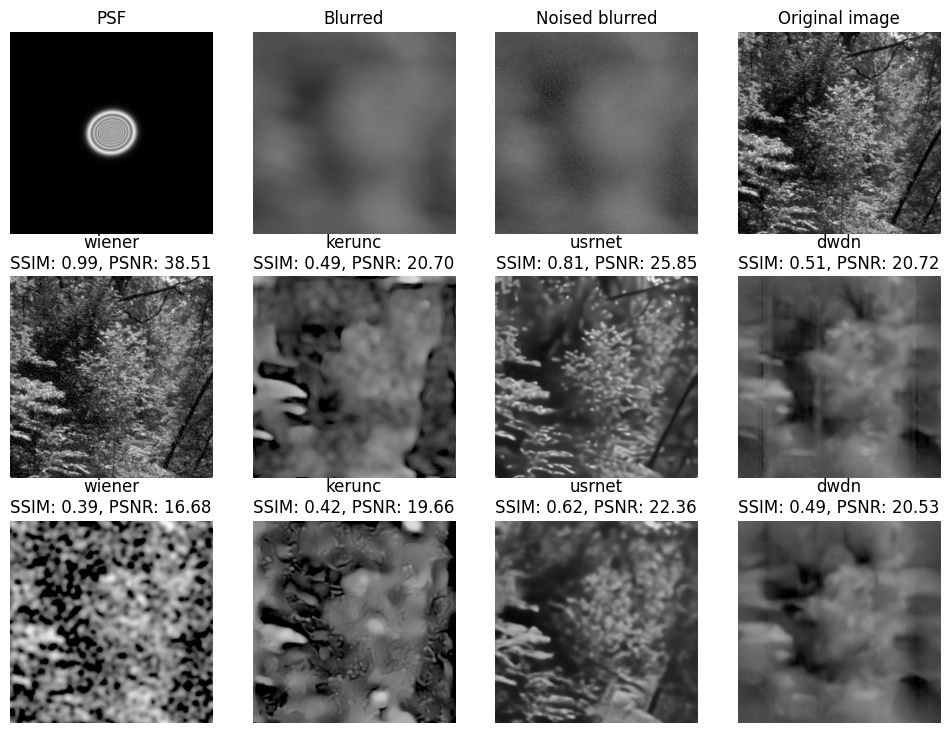

In [19]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/Sun-gray/im_32.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/medium-psf-0.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz(
    image=images[DISCRETIZATION_TYPE]['image'],
    psf=psf,
    blurred=images[DISCRETIZATION_TYPE]['blurred_no_noise'],
    noised_blurred=images[DISCRETIZATION_TYPE]['blurred_noise'],
    models=models,
    is_srgb=True,
)

## 2. Влияние квантизации на качество восстановления

In [20]:
def plot_by_group(
    result_set: pd.DataFrame,
    group_name: str,
    title: str,
    xlabel: str,
    text_rotation: int = 0,
    indices=None,
    name_mapping=None,
    figsize=(16, 5),
    fontsize=12,
):
    groups = result_set[group_name].unique()
    if indices is None:
        indices = [i for i in range(len(groups))]
    groups = [group.split('-')[-1] for group in groups[indices]]
    
    if name_mapping:
        groups = [name_mapping[group] for group in groups]

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, weight='semibold')

    for model in result_set['model'].unique():
        model_data = result_set[result_set['model'] == model]

        psnr_values = model_data['AVG(psnr)']
        axs[0].plot(groups, psnr_values.to_numpy()[indices], marker='o', label=model.split('_')[0])
        axs[0].tick_params(axis='x', which='major', labelsize=fontsize)
        axs[0].set_xlabel(xlabel, fontsize=fontsize)
        axs[0].set_ylabel('Среднее значение PSNR', fontsize=fontsize)
        axs[0].legend()

        ssim_values = model_data['AVG(ssim)']
        axs[1].plot(groups, ssim_values.to_numpy()[indices], marker='o', label=model)
        axs[1].set_xlabel(xlabel, fontsize=fontsize)
        axs[1].set_ylabel('Среднее значение SSIM', fontsize=fontsize)

    plt.show()


In [21]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model, discretization, ROUND(AVG(psnr), 4) AS 'AVG(psnr)', ROUND(AVG(ssim), 4) as 'AVG(ssim)'
FROM main_FULL_16_05_v2
WHERE noised == False AND discretization LIKE '%linrgb%' AND model != 'wiener_blind_noise'
GROUP BY  model, discretization
ORDER BY model, discretization DESC;
''', conn)

result_set

model discretization  AVG(psnr)  AVG(ssim)
0                    dwdn   linrgb_float    25.1233     0.7980
1                    dwdn    linrgb_8bit    24.9469     0.7928
2                    dwdn   linrgb_16bit    25.1233     0.7980
3                  kerunc   linrgb_float    25.3952     0.7926
4                  kerunc    linrgb_8bit    26.1911     0.8054
5                  kerunc   linrgb_16bit    25.3936     0.7926
6                  usrnet   linrgb_float    36.1174     0.9521
7                  usrnet    linrgb_8bit    32.7722     0.9090
8                  usrnet   linrgb_16bit    36.1177     0.9521
9   wiener_nonblind_noise   linrgb_float    54.7072     0.9907
10  wiener_nonblind_noise    linrgb_8bit    15.1025     0.3103
11  wiener_nonblind_noise   linrgb_16bit    51.4978     0.9894

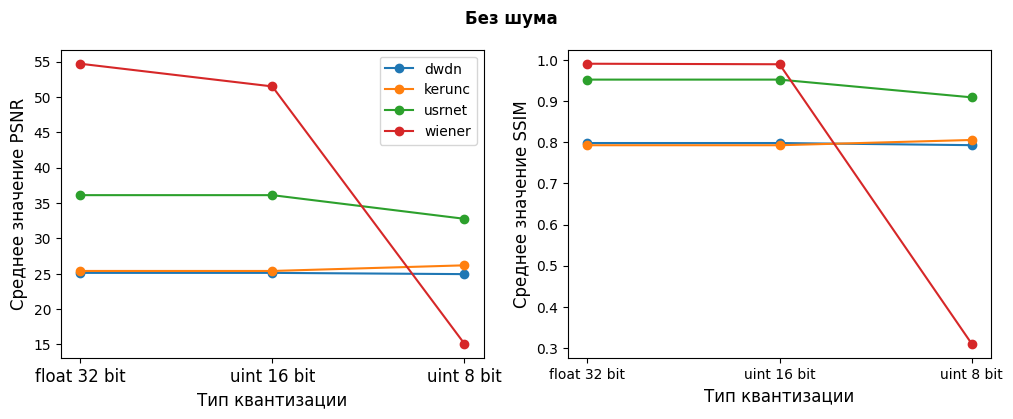

In [22]:
plot_by_group(
    result_set,
    'discretization',
    'Без шума',
    xlabel='Тип квантизации',
    indices=[0, 2, 1],
    name_mapping={'linrgb_float': 'float 32 bit', 'linrgb_16bit': 'uint 16 bit', 'linrgb_8bit': 'uint 8 bit'},
    figsize=(12, 4),
)

In [23]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model, discretization, ROUND(AVG(psnr), 4) AS 'AVG(psnr)', ROUND(AVG(ssim), 4) as 'AVG(ssim)'
FROM main_FULL_16_05_v2
WHERE noised == True AND discretization LIKE '%linrgb%' AND model != 'wiener_blind_noise'
GROUP BY  model, discretization
ORDER BY model, discretization DESC;
''', conn)

result_set

model discretization  AVG(psnr)  AVG(ssim)
0                    dwdn   linrgb_float    24.4087     0.7811
1                    dwdn    linrgb_8bit    24.3978     0.7802
2                    dwdn   linrgb_16bit    24.4087     0.7811
3                  kerunc   linrgb_float    24.7970     0.7786
4                  kerunc    linrgb_8bit    24.7818     0.7774
5                  kerunc   linrgb_16bit    24.7970     0.7786
6                  usrnet   linrgb_float    29.8351     0.8875
7                  usrnet    linrgb_8bit    29.7926     0.8866
8                  usrnet   linrgb_16bit    29.8351     0.8875
9   wiener_nonblind_noise   linrgb_float    20.3060     0.6715
10  wiener_nonblind_noise    linrgb_8bit    20.2889     0.6694
11  wiener_nonblind_noise   linrgb_16bit    20.3059     0.6715

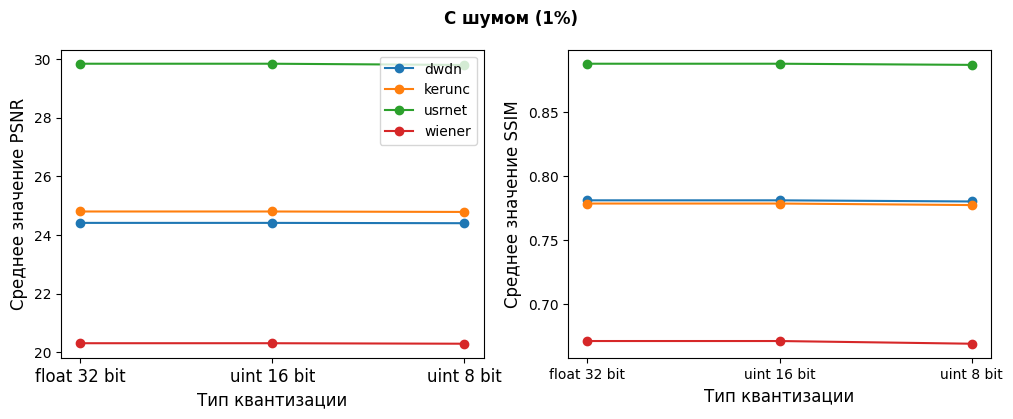

In [24]:
plot_by_group(
    result_set,
    'discretization',
    'С шумом (1%)',
    xlabel='Тип квантизации',
    indices=[0, 2, 1],
    name_mapping={'linrgb_float': 'float 32 bit', 'linrgb_16bit': 'uint 16 bit', 'linrgb_8bit': 'uint 8 bit'},
    figsize=(12, 4)
)

In [25]:
def _1d_to_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])


def viz_wiener_diff_quantization(
    images: dict,
    psf: np.ndarray,
    params: tp.Dict[str, float],
    params_8bit: tp.Dict[str, float],
    is_srgb: bool,
):
    if is_srgb:
        viz_preprocess = lambda image: linrgbf_to_srgbf(_1d_to_3d(image))
    else:
        viz_preprocess = lambda image: _1d_to_3d(image)
        
    _, ax = plt.subplots(2, 4, figsize=(12, 6))
    
    ax[0, 0].imshow(psf)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('PSF')

    ax[0, 1].imshow(viz_preprocess(images['linrgb_float']['blurred_no_noise']['1d']))
    ax[0, 1].axis('off')
    ax[0, 1].set_title('Blurred')

    ax[0, 2].imshow(viz_preprocess(images['linrgb_float']['image']))
    ax[0, 2].axis('off')
    ax[0, 2].set_title(f'Original image')
    
    ax[0, 3].imshow(np.ones((5, 5, 3)))
    ax[0, 3].axis('off')

    
    for i, discr_type in enumerate(['linrgb_float', 'linrgb_16bit', 'linrgb_8bit']): 
        image = images[discr_type]['image']
        restored = wiener_gray(images[discr_type]['blurred_no_noise']['1d'], psf, **params, clip=False)
        restored = np.clip(restored, 0, 1)
        
        ax[1, i].imshow(viz_preprocess(restored))
        ax[1, i].axis('off')
        ax[1, i].set_title(f'{discr_type} (C = {params["balance"]})\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}', fontsize=10)
    
    restored = wiener_gray(images[discr_type]['blurred_no_noise']['1d'], psf, **params_8bit, clip=False)
    restored = np.clip(restored, 0, 1)
    ax[1, 3].imshow(viz_preprocess(restored))
    ax[1, 3].axis('off')
    ax[1, 3].set_title(f'{discr_type} (C = {params_8bit["balance"]})\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}', fontsize=10)


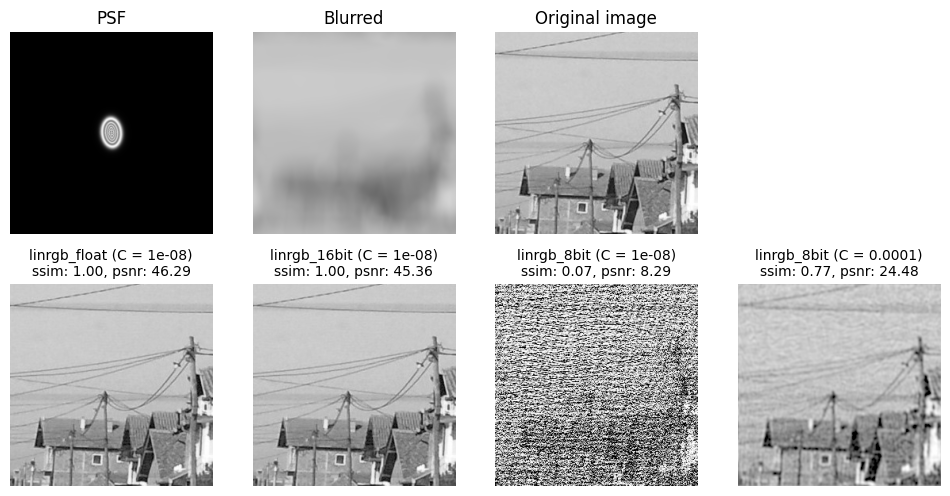

In [26]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/precomp/city/01 (43).jpg',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-6.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz_wiener_diff_quantization(
    images=images,
    psf=psf,
    params={'balance': 1e-8},
    params_8bit={'balance': 1e-4},
    is_srgb=True,
)

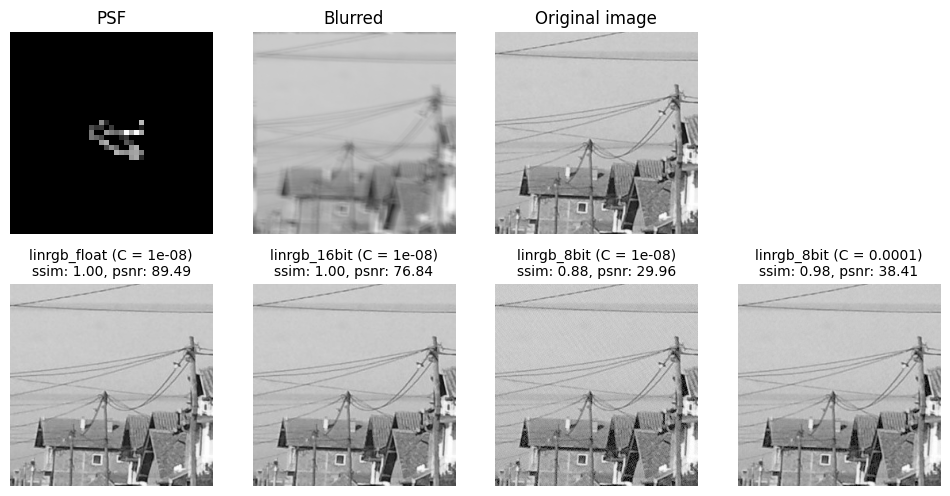

In [27]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/precomp/city/01 (43).jpg',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-18.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz_wiener_diff_quantization(
    images=images,
    psf=psf,
    params={'balance': 1e-8},
    params_8bit={'balance': 1e-4},
    is_srgb=True,
)

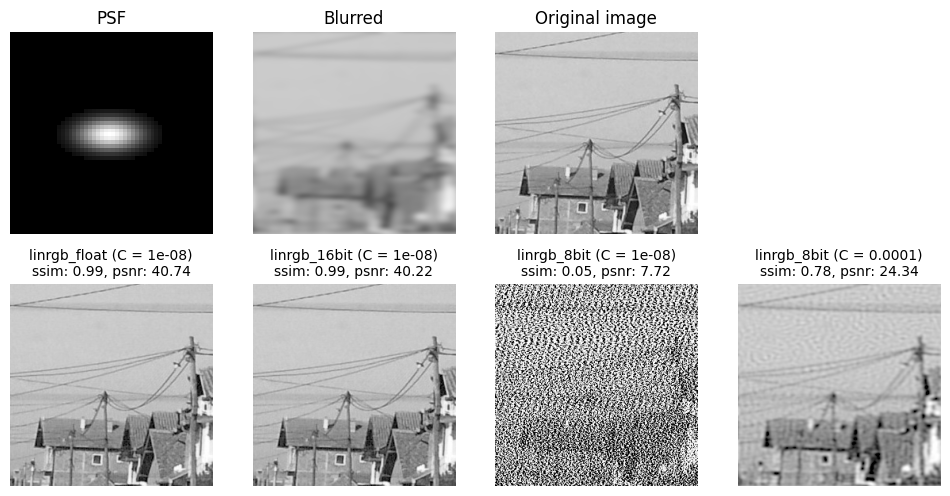

In [28]:
images, psf = MainTester.get_data(
    image_path='../datasets/gt/precomp/city/01 (43).jpg',
    psf_path='../datasets/kernels/gauss-blur/processed/synthetic/synthetic-18.npy',
    image_size=IMAGE_SIZE,
    noise_mu=NOISE_MU,
    noise_std=NOISE_STD,
)

viz_wiener_diff_quantization(
    images=images,
    psf=psf,
    params={'balance': 1e-8},
    params_8bit={'balance': 1e-4},
    is_srgb=True,
)

## 3. Влияние контента изображения на качество восстановления

In [29]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model, image_dataset, ROUND(AVG(psnr), 4) AS 'AVG(psnr)', ROUND(AVG(ssim), 4) as 'AVG(ssim)'
FROM main_FULL_16_05_v2
WHERE noised == False AND discretization == 'linrgb_float' AND model != 'wiener_blind_noise' 
GROUP BY  model, image_dataset
ORDER BY model, image_dataset DESC;
''', conn)

result_set.head()

model   image_dataset  AVG(psnr)  AVG(ssim)
0  dwdn             sun    25.4502     0.7713
1  dwdn   sca2023-texts    20.7042     0.7433
2  dwdn  sca2023-nature    27.0295     0.7814
3  dwdn   sca2023-icons    20.8596     0.8011
4  dwdn   sca2023-faces    28.3681     0.8787

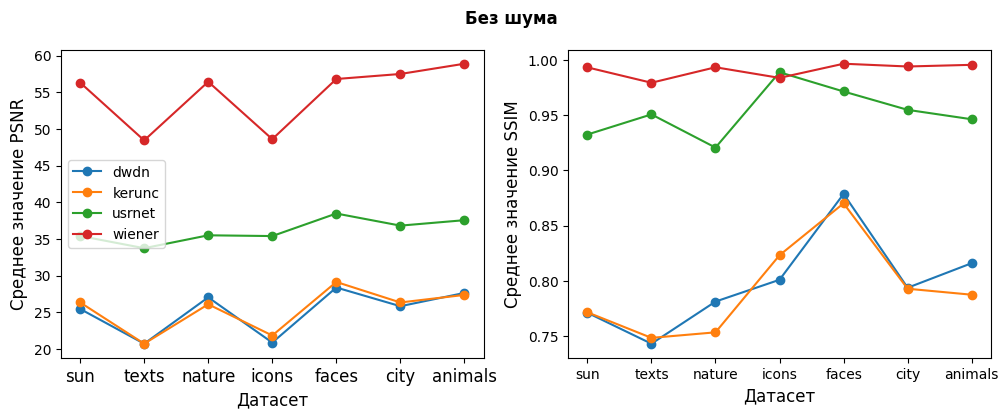

In [30]:
plot_by_group(result_set, 'image_dataset', 'Без шума', xlabel='Датасет', figsize=(12, 4), fontsize=12)

In [31]:
result_set

model    image_dataset  AVG(psnr)  AVG(ssim)
0                    dwdn              sun    25.4502     0.7713
1                    dwdn    sca2023-texts    20.7042     0.7433
2                    dwdn   sca2023-nature    27.0295     0.7814
3                    dwdn    sca2023-icons    20.8596     0.8011
4                    dwdn    sca2023-faces    28.3681     0.8787
5                    dwdn     sca2023-city    25.8195     0.7939
6                    dwdn  sca2023-animals    27.6321     0.8161
7                  kerunc              sun    26.3375     0.7717
8                  kerunc    sca2023-texts    20.7066     0.7486
9                  kerunc   sca2023-nature    26.0839     0.7536
10                 kerunc    sca2023-icons    21.8236     0.8233
11                 kerunc    sca2023-faces    29.1259     0.8702
12                 kerunc     sca2023-city    26.3283     0.7930
13                 kerunc  sca2023-animals    27.3609     0.7876
14                 usrnet              sun    35.3994     0.9324
15                 usrnet    sca2023-texts    33.7306     0.9506
16                 usrnet   sca2023-nature    35.4889     0.9206
17                 usrnet    sca2023-icons    35.3848     0.9887
18                 usrnet    sca2023-faces    38.4593     0.9713
19                 usrnet     sca2023-city    36.8079     0.9547
20                 usrnet  sca2023-animals    37.5511     0.9462
21  wiener_nonblind_noise              sun    56.3141     0.9931
22  wiener_nonblind_noise    sca2023-texts    48.4321     0.9792
23  wiener_nonblind_noise   sca2023-nature    56.4296     0.9932
24  wiener_nonblind_noise    sca2023-icons    48.5986     0.9836
25  wiener_nonblind_noise    sca2023-faces    56.8018     0.9964
26  wiener_nonblind_noise     sca2023-city    57.4884     0.9939
27  wiener_nonblind_noise  sca2023-animals    58.8860     0.9954

In [32]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model, image_dataset, ROUND(AVG(psnr), 4) AS 'AVG(psnr)', ROUND(AVG(ssim), 4) as 'AVG(ssim)'
FROM main_FULL_16_05_v2
WHERE noised == True AND discretization == 'linrgb_float' AND model != 'wiener_blind_noise'
GROUP BY  model, image_dataset
ORDER BY model, image_dataset DESC;
''', conn)

result_set.head()

model   image_dataset  AVG(psnr)  AVG(ssim)
0  dwdn             sun    24.5590     0.7507
1  dwdn   sca2023-texts    20.1549     0.7319
2  dwdn  sca2023-nature    26.0842     0.7575
3  dwdn   sca2023-icons    20.4272     0.7893
4  dwdn   sca2023-faces    27.6460     0.8626

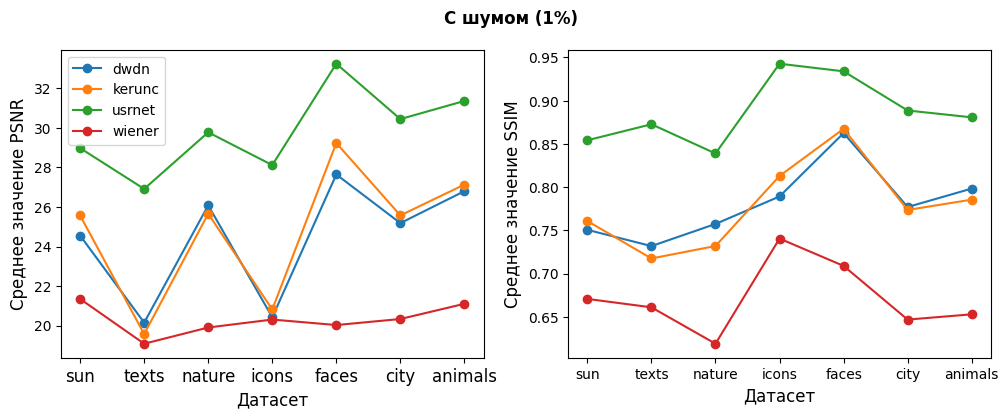

In [33]:
plot_by_group(result_set, 'image_dataset', 'С шумом (1%)', xlabel='Датасет', figsize=(12, 4), fontsize=12)

## 4. Влияние гамма-коррекции

In [34]:
def barplot_by_group(
    result_set: pd.DataFrame,
    title: str,
    xlabel: str,
    figsize=(16, 5),
    fontsize=12,
):
    models = result_set['model'].unique()
    models = [model.split('_')[0] for model in models]

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(title, weight='semibold')

    for quantization_level, color in zip(['linrgb_float', 'srgb_float'], ['green', 'blue']):
        quant_data = result_set[result_set['discretization'] == quantization_level]

        psnr_values = quant_data['AVG(psnr)']
        axs[0].bar(models, psnr_values.to_numpy(), label=quantization_level, alpha=0.6, color=color)
        axs[0].tick_params(axis='x', which='major', labelsize=fontsize)
        axs[0].set_xlabel(xlabel, fontsize=fontsize)
        axs[0].set_ylabel('Среднее значение PSNR', fontsize=fontsize)
        axs[0].legend()

        ssim_values = quant_data['AVG(ssim)']
        axs[1].bar(models, ssim_values.to_numpy(), label=quantization_level, alpha=0.6, color=color)
        axs[1].set_xlabel(xlabel, fontsize=fontsize)
        axs[1].set_ylabel('Среднее значение SSIM', fontsize=fontsize)

    plt.show()

In [35]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model, discretization, ROUND(AVG(psnr), 4) AS 'AVG(psnr)', ROUND(AVG(ssim), 4) as 'AVG(ssim)'
FROM main_FULL_16_05_v2
WHERE noised == False AND discretization in ('linrgb_float', 'srgb_float') AND model != 'wiener_blind_noise'
GROUP BY  model, discretization
ORDER BY model, discretization DESC;
''', conn)

result_set.head(10)

model discretization  AVG(psnr)  AVG(ssim)
0                   dwdn     srgb_float    22.4423     0.7806
1                   dwdn   linrgb_float    25.1233     0.7980
2                 kerunc     srgb_float    22.7238     0.7817
3                 kerunc   linrgb_float    25.3952     0.7926
4                 usrnet     srgb_float    21.1037     0.7215
5                 usrnet   linrgb_float    36.1174     0.9521
6  wiener_nonblind_noise     srgb_float    17.6641     0.5251
7  wiener_nonblind_noise   linrgb_float    54.7072     0.9907

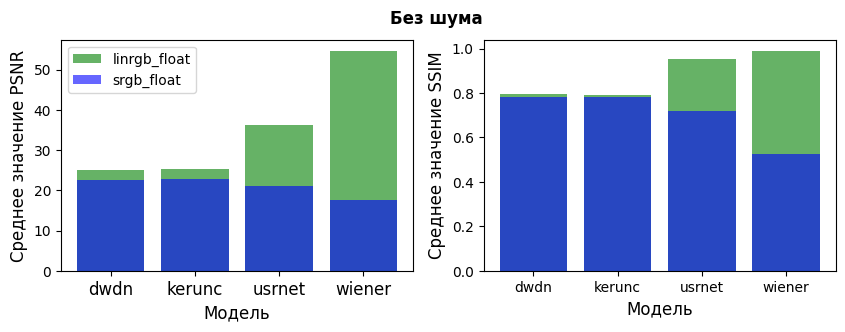

In [36]:
barplot_by_group(result_set, title='Без шума', xlabel='Модель', figsize=(10, 3))

In [37]:
conn = sqlite3.connect('/nbdb/results/metrics.db')

result_set = pd.read_sql_query(
'''
SELECT model, discretization, ROUND(AVG(psnr), 4) AS 'AVG(psnr)', ROUND(AVG(ssim), 4) as 'AVG(ssim)'
FROM main_FULL_16_05_v2
WHERE noised == True AND discretization in ('linrgb_float', 'srgb_float') AND model != 'wiener_blind_noise'
GROUP BY  model, discretization
ORDER BY model, discretization DESC;
''', conn)

result_set.head(10)


model discretization  AVG(psnr)  AVG(ssim)
0                   dwdn     srgb_float    21.7541     0.7549
1                   dwdn   linrgb_float    24.4087     0.7811
2                 kerunc     srgb_float    21.7823     0.7344
3                 kerunc   linrgb_float    24.7970     0.7786
4                 usrnet     srgb_float    19.7347     0.6689
5                 usrnet   linrgb_float    29.8351     0.8875
6  wiener_nonblind_noise     srgb_float    18.7285     0.6237
7  wiener_nonblind_noise   linrgb_float    20.3060     0.6715

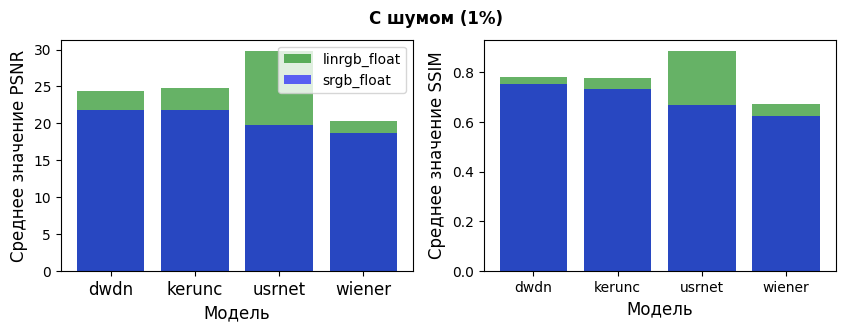

In [38]:
barplot_by_group(result_set, title='С шумом (1%)', xlabel='Модель', figsize=(10, 3))